<a href="https://colab.research.google.com/github/entenam/QNLP/blob/main/SimpleQNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install lambeq

In [ ]:
import torch
import random
import numpy as np

# set seed for reproducibility
SEED = 12
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
pip install lambeq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.0/209.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.3/364.3 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 15.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.wh

# **Tokenisation**

In [ ]:
from lambeq import SpacyTokeniser

tokeniser = SpacyTokeniser() # Tokeniser class
sentence ="Skillful man cooks tasty dinner"
tokens = tokeniser.tokenise_sentence(sentence) # Tokenise a list of sentences. It takes input as a list of sentences and returns a list of tokenised sentences
tokens

['Skillful', 'man', 'cooks', 'tasty', 'dinner']

In [ ]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            line = line.split(',')
            labels.append(int(line[2]))
            sentences.append((line[0], line[1]))
    return labels, sentences
train_labels, train_data = read_data('/content/sample_data/mc_pair_train_data.csv')
dev_labels, dev_data = read_data('/content/sample_data/mc_pair_dev_data.csv')
test_labels, test_data = read_data('/content/sample_data/mc_pair_test_data.csv')
print(list(zip(train_data[:5], train_labels[:5])))

[(('person runs program .', 'skillful person cooks meal .'), 0), (('skillful man bakes dinner .', 'woman runs program .'), 0), (('man bakes tasty dinner .', 'person cooks meal .'), 1), (('woman runs application .', 'skillful man prepares program .'), 1), (('man bakes tasty meal .', 'man runs software .'), 0)]


# **Creating and parameterizing diagrams**
The first step in this process is to convert the sentences into string diagrams using the BobcatParser, a state-of-the-art combinatory categorial grammar parser included with lambeq. BobCatParser expects a list of strings, so we will flatten our paired data for the parsing steps and re-pair the sentences later.

In [ ]:
train_data_l, train_data_r = zip(*train_data)
train_data_unpaired = list(train_data_l) + list(train_data_r)
dev_data_l, dev_data_r = zip(*dev_data)
dev_data_unpaired = list(dev_data_l) + list(dev_data_r)
test_data_l, test_data_r = zip(*test_data)
test_data_unpaired = list(test_data_l) + list(test_data_r)

In [ ]:
from lambeq import BobcatParser

reader = BobcatParser(verbose='text')

raw_train_diagrams = reader.sentences2diagrams(train_data_unpaired)
raw_dev_diagrams = reader.sentences2diagrams(dev_data_unpaired)
raw_test_diagrams = reader.sentences2diagrams(test_data_unpaired)

Evaluating checksum: 0.0%|          |0.000/1.533GB [00:00<?]

Extracting model...


Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


# **String Diagram Generation**

In [ ]:
#from lambeq import cups_reader

# Create string diagrams based on cups reader
#cups_diagram = cups_reader.sentence2diagram(sentence)

#cups_diagram.draw(figsize=(12,2), fontsize=12)

# **Simplifying Diagrams**

The diagrams can be simplified by rmeoving cups in string diagram; because a cup in a string diagram corresponds to a Bell effect postselection in a quantum circuit, removing cups can reduce the number of postselections per diagram, making it more efficient to evaluate them.

In [ ]:
from lambeq import RemoveCupsRewriter

rewriter = RemoveCupsRewriter()
rewritten_diagram=rewriter.rewrite(raw_train_diagrams)# for diagram in sentence
rewritten_diagram.draw()

#from lambeq import remove_cups

#train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
#dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
#test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

AttributeError: 'list' object has no attribute 'dom'

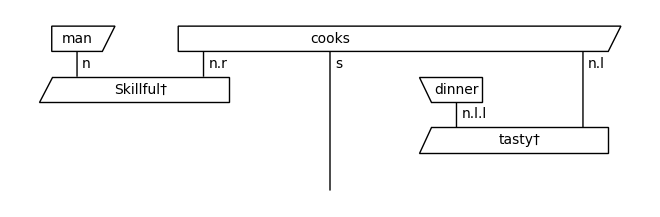

In [ ]:
#Simplifying diagrams
from lambeq import RemoveCupsRewriter

rewriter = RemoveCupsRewriter()
rewritten_diagram=rewriter.rewrite(diagram1)# for diagram in sentence
rewritten_diagram.draw()

# **Creating circuits**
To run the experiments on a quantum computer, a quantum ansatz is applied to the string diagrams. For this experiment, an IQPAnsatz is used, where one-qubit systems represent noun wires (n) and sentence wires (s).

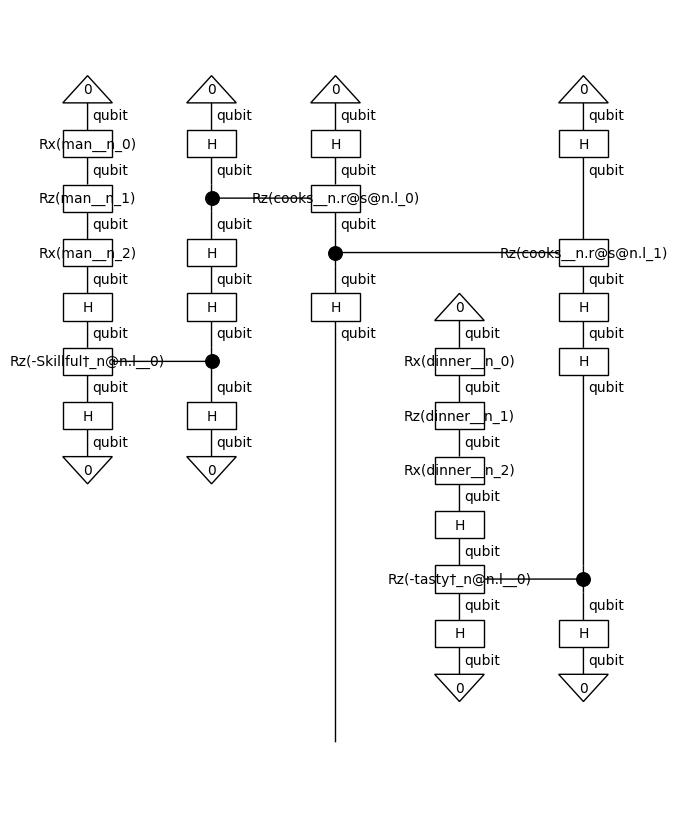

In [ ]:
from lambeq import AtomicType, IQPAnsatz
#Standard pregroup atomic types.NOUN= Ty(n)
#Instantaneous Quantum Polynomial ansatz.
#An IQP ansatz interleaves layers of Hadamard gates with diagonal unitaries. This class uses n_layers-1 adjacent CRz gates to implement each diagonal unitary.
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},n_layers=1, n_single_qubit_params=3)
# n_layers : int;The number of layers used by the ansatz.n_single_qubit_params : int, default: 3; The number of single qubit rotations used by the ansatz.            It only affects wires that `ob_map` maps to a single qubit.
train_circuits = ansatz(rewritten_diagram)
train_circuits.draw(figsize=(6, 8))

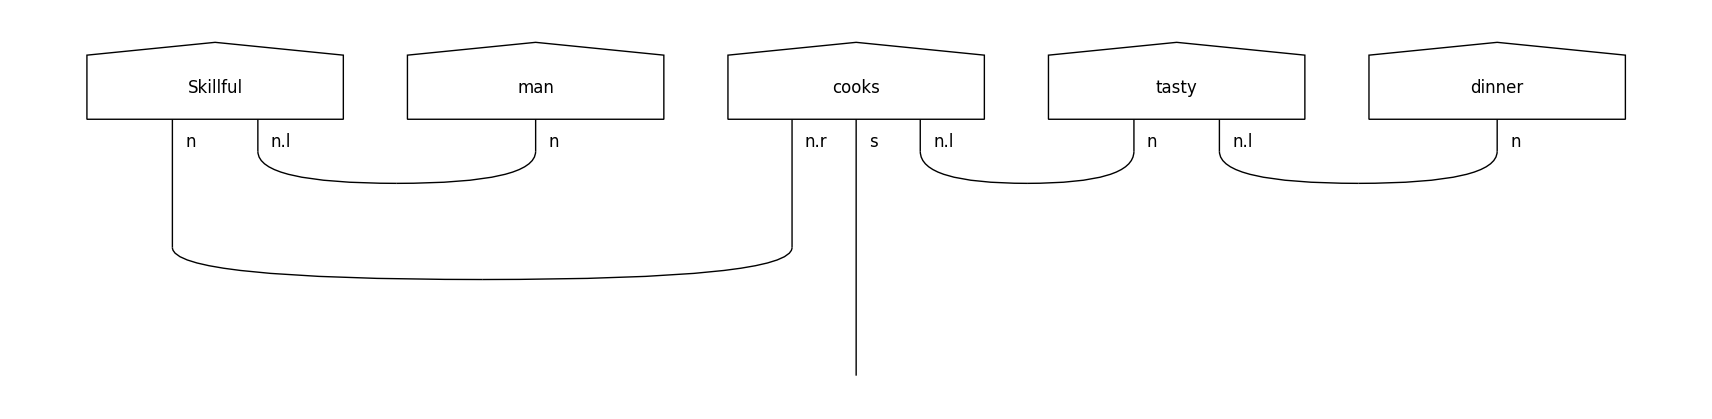

In [ ]:
from lambeq import BobcatParser
# converts sentences to stirng diagrams using the BobCatParser, a state of the art Combinatory categorical grammar parserincluded with lambeq
parser = BobcatParser(verbose='suppress')
# Setting verbose='suppress' instructs the system to reduce or entirely eliminate these informational messages, status updates, or debugging output, which can be especially useful in production environments or when running automated processes where excessive verbosity might be unnecessary or undesirable.

diagram1 = parser.sentence2diagram(tokens, tokenised=True)
# Parse multiple sentences into a list of CCGTrees.
diagram1.draw(figsize=(23,4), fontsize=12)